# Классификация марки авто по изображениям

### Основная идея решения: взять предобученую на ImageNet сеть EfficientNetB7 и дообучить под задачу. 



In [1]:
# Обновление tensorflow
!pip install tensorflow --upgrade
# Загрузка модели efficientnet
!pip install -q efficientnet
# Загружаем обвязку под keras для использования продвинутых библиотек аугментации, например, albuminations
!pip install git+https://github.com/mjkvaak/ImageDataAugmentor

  Cloning https://github.com/mjkvaak/ImageDataAugmentor to /tmp/pip-req-build-sdobrllm
  Running command git clone -q https://github.com/mjkvaak/ImageDataAugmentor /tmp/pip-req-build-sdobrllm


In [2]:
!nvidia-smi

Sun Mar  7 05:31:49 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    31W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import zipfile
import csv
import sys
import os

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
import efficientnet.tfkeras as efn

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
    
# слои, которые нам пригодятся
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

from sklearn.model_selection import train_test_split, StratifiedKFold

import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

print(os.listdir("../input"))
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

['sf-dl-car-classification']
Python       : 3.7.9 | packaged by conda-forge | (default, Dec  9 2020, 21:08:20) 
Numpy        : 1.19.5
Tensorflow   : 2.4.1
Keras        : 2.4.0


In [4]:
!pip freeze > requirements.txt

**Работаем с Tensorflow v2**

# Основные настройки

In [8]:
# В setup выносим основные настройки: так удобнее их перебирать в дальнейшем.

EPOCHS               = 10  # эпох на обучение
BATCH_SIZE           = 32 # уменьшаем batch если сеть большая, иначе не влезет в память на GPU
LR                   = 1e-3
VAL_SPLIT            = 0.2 # сколько данных выделяем на тест = 20%

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 224 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = '../input/sf-dl-car-classification/'
PATH = "../working/car/" # рабочая директория

# Устанавливаем конкретное значение random seed для воспроизводимости

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)  
PYTHONHASHSEED = 0

# EDA / Анализ данных

In [9]:
#train_df = pd.read_csv(DATA_PATH+"train.csv")
train_df = pd.read_csv(DATA_PATH+"train.csv")
sample_submission = pd.read_csv(DATA_PATH+"sample-submission.csv")
train_df.head()

,Id,Category
0,100155.jpg,0
1,100306.jpg,0
2,100379.jpg,0
3,100380.jpg,0
4,100389.jpg,0


In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB


In [11]:
train_df.Category.value_counts()
# распределение классов достаточно равномерное - это хорошо

1    1971
8    1765
6    1733
5    1631
0    1613
3    1528
2    1458
4    1400
9    1255
7    1207
Name: Category, dtype: int64

In [12]:
print('Распаковываем картинки')
# Will unzip the files so that you can see them..
for data_zip in ['train.zip', 'test.zip']:
    with zipfile.ZipFile("../input/sf-dl-car-classification/"+data_zip,"r") as z:
        z.extractall(PATH)
        
print(os.listdir(PATH))

Распаковываем картинки
['train', 'test_upload']


Пример картинок (random sample)


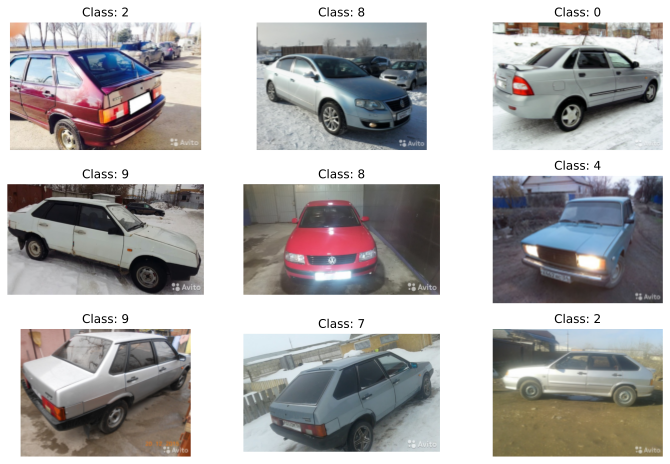

In [14]:
print('Пример картинок (random sample)')
plt.figure(figsize=(12,8))

random_image = train_df.sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(PATH+f'train/{random_image_cat[index]}/{path}')
    plt.subplot(3,3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

Посмотрим на примеры картинок и их размеры, чтобы понимать, как их лучше обработать и сжимать.

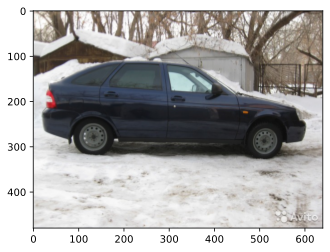

(640, 480)

In [15]:
image = PIL.Image.open(PATH+'/train/0/100380.jpg')
imgplot = plt.imshow(image)
plt.show()
image.size

Всего 10 классов автомобилей: в основном это ВАЗовские модели: Нива, Приора, Калина и семейство 2109 - 21099 которые невозможно отличить друг от друга спереди или по задним фонарям.

### Классы -- модели авто, научимся их предсказывать!

# Подготовка данных

### Аугментация данных   

In [16]:
from ImageDataAugmentor.image_data_augmentor import *
import albumentations

In [17]:
#### Аугментация данных важна, когда мы работаем с небольшим датасетом. Это как раз наш случай.

AUGMENTATIONS = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5),
    albumentations.Rotate(limit=30, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5),
    albumentations.OneOf([
        albumentations.CenterCrop(height=224, width=200),
        albumentations.CenterCrop(height=200, width=224),
    ],p=0.5),
    albumentations.OneOf([
        albumentations.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3),
        albumentations.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1)
    ],p=0.5),
    albumentations.GaussianBlur(p=0.05),
    albumentations.HueSaturationValue(p=0.5),
    albumentations.RGBShift(p=0.5),
    albumentations.FancyPCA(alpha=0.1, always_apply=False, p=0.5),
    albumentations.Resize(IMG_SIZE, IMG_SIZE)
])

train_datagen = ImageDataAugmentor(
        rescale=1./255,
        augment = AUGMENTATIONS,
        validation_split=VAL_SPLIT,
        )
        
test_datagen = ImageDataAugmentor(rescale=1./255)

### Генерация данных

In [18]:
# Завернем наши данные в генератор:

train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

/opt/conda/lib/python3.7/site-packages/ImageDataAugmentor/image_data_augmentor.py:332: UserWarning: Passing `seed` in `.flow_from_directory` has been been removed: pass  `seed` as parameter in `ImageDataAugmentor(..., seed=...)` instead
  warnings.warn('Passing `seed` in `.flow_from_directory` has been been removed: pass  `seed` '


Found 12452 images belonging to 10 classes.
Found 3109 images belonging to 10 classes.


# Построение модели   
Первоначально использовалась модель на **FixEfficientNet-B6**, но с ней не удалось выйти вышt 96% точности. Поэтому используем предобученную модель FixEfficientNet-B7, в которой больше параметров

# Загружаем предобученную сеть FixEfficientNet-B7:

In [19]:
base_model = efn.EfficientNetB7(weights='imagenet', include_top=False, input_shape=input_shape)

In [20]:
base_model.summary()

Model: "efficientnet-b7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 64) 1728        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 64) 256         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 64) 0           stem_bn[0][0]                    
____________________________________________________________________________________

__________________________________________________________________________________________________
block7b_se_reshape (Reshape)    (None, 1, 1, 3840)   0           block7b_se_squeeze[0][0]         
__________________________________________________________________________________________________
block7b_se_reduce (Conv2D)      (None, 1, 1, 160)    614560      block7b_se_reshape[0][0]         
__________________________________________________________________________________________________
block7b_se_expand (Conv2D)      (None, 1, 1, 3840)   618240      block7b_se_reduce[0][0]          
__________________________________________________________________________________________________
block7b_se_excite (Multiply)    (None, 7, 7, 3840)   0           block7b_activation[0][0]         
                                                                 block7b_se_expand[0][0]          
__________________________________________________________________________________________________
block7b_pr

In [21]:
# Для начала заморозим веса EfficientNetB7 и обучим только "голову". 
# Делаем это для того, чтобы хорошо обученные признаки на Imagenet не затирались в самом начале нашего обучения
base_model.trainable = False

In [22]:
import tensorflow.keras as keras
import tensorflow.keras.models as M
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import tensorflow.keras.callbacks as C
from tensorflow.keras.preprocessing import image

In [23]:
# Устанавливаем новую "голову" (head)

model=M.Sequential()
model.add(base_model)
model.add(L.GlobalAveragePooling2D(),) # объединяем все признаки в единый вектор 

# Экспериментируем с архитектурой - добавляем ещё один полносвязный слой, dropout и batch-нормализацию

model.add(L.Dense(256, activation='relu'))
model.add(L.BatchNormalization())
model.add(L.Dropout(0.25))
model.add(L.Dense(CLASS_NUM, activation='softmax'))

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b7 (Functional) (None, 7, 7, 2560)        64097680  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2560)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               655616    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 64,756,890
Trainable params: 658,698
Non-trainable params: 64,098,192
______________________________________

In [25]:
# сколько слоев
print(len(model.layers))

6


In [26]:
len(model.trainable_variables)

6

In [27]:
# Check the trainable status of the individual layers
for layer in model.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.functional.Functional object at 0x7f9dda37fdd0> False
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7f9d470bed10> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f9d903bb690> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f9d47084650> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f9d47059f10> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f9d47056d10> True


# **Fit**

## Обучение модели

Добавим ModelCheckpoint чтоб сохранять прогресс обучения модели и можно было потом подгрузить и дообучить модель.

In [28]:
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')
earlystop = EarlyStopping(monitor='accuracy', patience=5, restore_best_weights=True)
callbacks_list = [checkpoint, earlystop]

Обучаем:

In [29]:
# Обучаем

history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples//train_generator.batch_size,
    validation_data = test_generator, 
    validation_steps = test_generator.samples//test_generator.batch_size,
    epochs = EPOCHS,
    callbacks = callbacks_list
    )

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
389/389 [==============================] - 206s 483ms/step - loss: 2.0726 - accuracy: 0.3354 - val_loss: 1.1751 - val_accuracy: 0.5677

Epoch 00001: saving model to best_model.hdf5
Epoch 2/10
389/389 [==============================] - 180s 462ms/step - loss: 1.4991 - accuracy: 0.4754 - val_loss: 1.0348 - val_accuracy: 0.6421

Epoch 00002: saving model to best_model.hdf5
Epoch 3/10
389/389 [==============================] - 179s 459ms/step - loss: 1.4044 - accuracy: 0.5006 - val_loss: 1.0020 - val_accuracy: 0.6401

Epoch 00003: saving model to best_model.hdf5
Epoch 4/10
389/389 [==============================] - 178s 458ms/step - loss: 1.3265 - accuracy: 0.5351 - val_loss: 0.9414 - val_accuracy: 0.6704

Epoch 00004: saving model to best_model.hdf5
Epoch 5/10
389/389 [==============================] - 177s 456ms/step - loss: 1.2797 - accuracy: 0.5481 - val_loss: 0.9822 - val_accuracy: 0.6540

Epoch 00005: saving model to best_model.hdf5
Epoch 6/10
389/389 [====================

In [31]:
scores = model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


98/98 [==============================] - 36s 366ms/step - loss: 0.8505 - accuracy: 0.6996
Accuracy: 69.96%


In [30]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)
model.save('../working/model_last.hdf5')
model.load_weights('best_model.hdf5')

# Step 2 - FineTuning - обучение половины весов EfficientNetb7   

Разморозку можно было вести постепенно, например добавить еще итерацию на 75%. Но даже при таком количестве еле-еле удалось вписаться в максимальное время сессии 9 часов.

In [32]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  806


In [33]:
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = len(base_model.layers)//2

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [34]:
len(base_model.trainable_variables)

354

In [35]:
# Check the trainable status of the individual layers
for layer in model.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.functional.Functional object at 0x7f9dda37fdd0> True
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7f9d470bed10> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f9d903bb690> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f9d47084650> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f9d47059f10> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f9d47056d10> True


In [36]:
EPOCHS               = 10  # эпох на обучение
BATCH_SIZE           = 16 # уменьшаем batch если сеть большая, иначе не влезет в память на GPU
LR                   = 1e-4
VAL_SPLIT            = 0.2 # сколько данных выделяем на тест = 20%

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 224 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = '../input/'
PATH = "../working/car/" # рабочая директория

# Устанавливаем конкретное значение random seed для воспроизводимости

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)  
PYTHONHASHSEED = 0

# Завернем наши данные в генератор:

train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

# Добавим ModelCheckpoint чтоб сохранять прогресс обучения модели и можно было потом подгрузить и дообучить модель.    
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['accuracy'] , verbose = 1  , mode = 'max')
earlystop = EarlyStopping(monitor='accuracy', patience=5, restore_best_weights=True)
callbacks_list = [checkpoint, earlystop]

# Обучаем

history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples//train_generator.batch_size,
    validation_data = test_generator, 
    validation_steps = test_generator.samples//test_generator.batch_size,
    epochs = EPOCHS,
    callbacks = callbacks_list
    )

Found 12452 images belonging to 10 classes.
Found 3109 images belonging to 10 classes.
Epoch 1/10
778/778 [==============================] - 272s 320ms/step - loss: 1.3686 - accuracy: 0.5403 - val_loss: 0.4058 - val_accuracy: 0.8499

Epoch 00001: saving model to best_model.hdf5
Epoch 2/10
778/778 [==============================] - 244s 313ms/step - loss: 0.5377 - accuracy: 0.8119 - val_loss: 0.2617 - val_accuracy: 0.9040

Epoch 00002: saving model to best_model.hdf5
Epoch 3/10
778/778 [==============================] - 245s 314ms/step - loss: 0.4115 - accuracy: 0.8571 - val_loss: 0.2251 - val_accuracy: 0.9214

Epoch 00003: saving model to best_model.hdf5
Epoch 4/10
778/778 [==============================] - 244s 313ms/step - loss: 0.3095 - accuracy: 0.8905 - val_loss: 0.2120 - val_accuracy: 0.9285

Epoch 00004: saving model to best_model.hdf5
Epoch 5/10
778/778 [==============================] - 244s 313ms/step - loss: 0.2568 - accuracy: 0.9097 - val_loss: 0.1886 - val_accuracy: 0.9346

KeyboardInterrupt: 

In [ ]:
scores = model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

154/195 [======================>.......] - ETA: 7s - loss: 0.1585 - accuracy: 0.9456

In [ ]:
# Сохраним модель
model.save('../working/model_step2.hdf5')
model.load_weights('best_model.hdf5')

# Step 3 - FineTuning - разморозка всей сети EfficientNetB7 и дообучение

In [ ]:
base_model.trainable = True

In [ ]:
# В setup выносим основные настройки: так удобнее их перебирать в дальнейшем.

EPOCHS               = 8  # эпох на обучение
BATCH_SIZE           = 8 # уменьшаем batch если сеть большая, иначе не влезет в память на GPU
LR                   = 1e-5
VAL_SPLIT            = 0.2 # сколько данных выделяем на тест = 20%

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 224 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = '../input/'
PATH = "../working/car/" # рабочая директория

# Устанавливаем конкретное значение random seed для воспроизводимости

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)  
PYTHONHASHSEED = 0

# Завернем наши данные в генератор:

train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

# Добавим ModelCheckpoint чтоб сохранять прогресс обучения модели и можно было потом подгрузить и дообучить модель.    
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['accuracy'] , verbose = 1  , mode = 'max')
earlystop = EarlyStopping(monitor='accuracy', patience=5, restore_best_weights=True)
callbacks_list = [checkpoint, earlystop]

# Обучаем

history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples//train_generator.batch_size,
    validation_data = test_generator, 
    validation_steps = test_generator.samples//test_generator.batch_size,
    epochs = EPOCHS,
    callbacks = callbacks_list
    )

In [ ]:
model.save('../working/model_step3.hdf5')
model.load_weights('best_model.hdf5')

In [ ]:
scores = model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
#%cd /kaggle/working
#from IPython.display import FileLink
#FileLink(r'model_step3.hdf5')

In [ ]:
#model = keras.models.load_model('../input/train-models/model_step3.hdf5')
#model.summary()

# Step 4 - увеличим размер изображения и понизим уровень аугментации  

In [ ]:
IMG_SIZE             = 512
BATCH_SIZE           = 3 
LR                   = 1e-5
EPOCHS               = 6  # эпох на обучение

input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

AUGMENTATIONS = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5),
    albumentations.Rotate(limit=30, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5)
])

train_datagen = ImageDataAugmentor(
        rescale=1./255,
        augment = AUGMENTATIONS,
        validation_split=VAL_SPLIT,
        )
        
test_datagen = ImageDataAugmentor(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

Создадим сеть заново с новым размером входных данных

In [ ]:
base_model = efn.EfficientNetB7(weights='imagenet', include_top=False, input_shape=input_shape)

In [ ]:
#EPOCHS               = 4  # эпох на обучение
#BATCH_SIZE           = 3 # уменьшаем batch если сеть большая, иначе не влезет в память на GPU
LR                   = 1e-5

model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

model.load_weights('best_model.hdf5') # Подгружаем ранее обученные веса
#model.load_weights('../input/train-models/model_last.hdf5')

callbacks_list = [checkpoint, earlystop]

# Обучаем

history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples//train_generator.batch_size,
    validation_data = test_generator, 
    validation_steps = test_generator.samples//test_generator.batch_size,
    epochs = EPOCHS,
    callbacks = callbacks_list
    )

In [ ]:
model.save('../working/model_step4.hdf5')
model.load_weights('best_model.hdf5')

In [ ]:
scores = model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

# Предсказание на тестовых данных

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

In [ ]:
test_sub_generator.samples

In [ ]:
test_sub_generator.reset()
predictions = model.predict_generator(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

In [ ]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission.csv', index=False)
print('Save submit')

Итоговая оценка на *Kaggle* - 0.97348 и итоговое 21 место на тот момент.

# Test Time Augmentation

https://towardsdatascience.com/test-time-augmentation-tta-and-how-to-perform-it-with-keras-4ac19b67fb4d

Аугментируем тестовые изображения и сделаем несколько предсказаний одной картинки в разном виде. Взяв среднее значение из нескольких предсказаний получим итоговое предсказание.

In [ ]:
model.load_weights('best_model.hdf5')

In [ ]:
AUGMENTATIONS = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5),
    albumentations.Rotate(limit=30, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5),
    albumentations.OneOf([
        albumentations.CenterCrop(height=220, width=200),
        albumentations.CenterCrop(height=200, width=220),
    ],p=0.5),
    albumentations.OneOf([
        albumentations.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3),
        albumentations.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1)
    ],p=0.5),
    albumentations.GaussianBlur(p=0.05),
    albumentations.HueSaturationValue(p=0.5),
    albumentations.RGBShift(p=0.5),
    albumentations.FancyPCA(alpha=0.1, always_apply=False, p=0.5),
    albumentations.Resize(IMG_SIZE, IMG_SIZE)
])
      
test_datagen = ImageDataAugmentor( 
    rescale=1./255,
    augment = AUGMENTATIONS,
    validation_split=VAL_SPLIT,
)

In [ ]:
test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

In [ ]:
tta_steps = 10 # берем среднее из 10 предсказаний
predictions = []

for i in range(tta_steps):
    preds = model.predict_generator(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
    predictions.append(preds)

pred = np.mean(predictions, axis=0)

In [ ]:
predictions = np.argmax(pred, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

In [ ]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission_TTA.csv', index=False)
print('Save submit')

ТТА только ухудшил результат до 0,9277

In [ ]:
# Clean PATH
import shutil
shutil.rmtree(PATH)

# Вывод

В данном проекте была создана нейросеть для классификации автомобилей по фото. Изначально использовалась сеть **FixEfficietB6** 

- далее изменена на **FixEfficientB7**
- использовалась аугментация данных, т.к. датасет не очень большой 
- обучение и постепенная разморозка сети (ограничена временем сессии на Кагл - 9 часов)
- увеличение размера изображения и уменьшение размера батча (из-за ограничений памяти) 
- использование callback list (оставлены только 2)
- использование различных оптимизаторов (Adam, Adamax, Nadam) - в итоге все вернулось к Adam

В данном проекте не удалось реализовать, все что было задумано, и связано с ограничением времени. Чтобы довести полностью сессию нужно 9 часов, и времени GPU на Кагле как раз хватает, чтобы посмотреть работу оптимизаторов и на выходные полностью прогнать весь ноутбук.

Что еще можно было сделать:  
при просмотре картинок стало ясно, что слишком много похожих фото и даже человеку сложно из различить. Стоило еще раз залезть на авто.ру и насобирать картинок, но на это уже не хватило времени.  

P.S. По лидерборду видно, как быстро растет точность сетей, всего одному человеку, из тех, кто делал проект около года назад (наверно Xception) удалось превысить 0,97 - и наверно это было первое местоа сейчас это только 31 место 